# Setup

## Packages

In [ ]:
# data analysis
import pandas as pd
import numpy as np
import scanpy as sc

# cell-cell communication
import liana as li
import cell2cell as c2c

# plotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
from plotnine.options import set_option
from collections import defaultdict

# readability
import warnings

warnings.filterwarnings("ignore")

set_option("limitsize", False)

True

In [ ]:
# NOTE: to use CPU instead of GPU, set use_gpu = False
use_gpu = True

if use_gpu:
    import torch
    import tensorly as tl

    device = "cuda" if torch.cuda.is_available() else "cpu"
    if device == "cuda":
        tl.set_backend("pytorch")
else:
    device = "cpu"

device

'cuda'

## Functions

### Embedding shuffled

In [ ]:
def embedding_shuffled(
    adata,
    basis="X_umap",
    legend_fontsize=12,
    legend_fontoutline=3,
    add_outline=False,
    frameon=False,
    size=None,
    show=False,
    *args,
    **kwargs,
):
    np.random.seed(0)
    random_indices = np.random.permutation(list(range(adata.shape[0])))

    if size is None:
        size = 500000 / adata.n_obs

    sc.pl.embedding(
        adata=adata[random_indices, :],
        basis=basis,
        legend_fontsize=legend_fontsize,
        legend_fontoutline=legend_fontoutline,
        add_outline=add_outline,
        frameon=frameon,
        size=size,
        show=show,
        *args,
        **kwargs,
    )

## Dataset

In [ ]:
data_path = "/path/to/data/"

In [ ]:
adata = sc.read_h5ad(f"{data_path}trdcko_cleaned.h5ad")

# Ligand-Receptor inference by sample

## Running Liana

In [ ]:
adata = adata[
    adata.obs["cell_type"].isin(
        ["γδDETC", "αβDETC", "αβDETC Tbx21+", "DETC cycling", "LC", "LC cycling"]
    )
].copy()

In [ ]:
adata.X = adata.layers["raw_data"].copy()

sc.pp.normalize_total(adata, target_sum=10000)
sc.pp.log1p(adata)

In [ ]:
adata.obs["replicate_overall"] = (
    adata.obs["batch"].astype(str)
    + "_"
    + adata.obs["genotype"].astype(str)
    + "_"
    + adata.obs["replicate"].astype(str)
)

In [ ]:
sample_key = "replicate_overall"
condition_key = "genotype"
groupby = "cell_type"

In [ ]:
li.mt.rank_aggregate.by_sample(
    adata,
    groupby=groupby,
    resource_name="mouseconsensus",
    sample_key=sample_key,
    use_raw=False,
    verbose=True,
    n_perms=None,
    return_all_lrs=True,
)

In [ ]:
from liana.method import (
    singlecellsignalr,
    connectome,
    cellphonedb,
    natmi,
    logfc,
    cellchat,
    geometric_mean,
)

In [ ]:
methods = [
    logfc,
    geometric_mean,
    singlecellsignalr,
    connectome,
    cellphonedb,
    natmi,
    cellchat,
]
new_rank_aggregate = li.mt.AggregateClass(li.mt.aggregate_meta, methods=methods)

In [ ]:
new_rank_aggregate.by_sample(
    adata,
    sample_key=sample_key,
    groupby=groupby,
    resource_name="mouseconsensus",
    use_raw=False,
    verbose=True,
    inplace=True,
    return_all_lrs=True,
)

## 4D Tensor

### Buidling tensor from liana

In [ ]:
tensor = li.multi.to_tensor_c2c(
    adata,
    sample_key=sample_key,
    score_key="magnitude_rank",
    how="outer",
    context_order=[
        "TcrdKO1_wt_1",
        "TcrdKO1_wt_2",
        "TcrdKO2_wt_1",
        "TcrdKO2_wt_2",
        "TcrdKO1_ko_1",
        "TcrdKO1_ko_2",
        "TcrdKO2_ko_1",
        "TcrdKO2_ko_2",
    ],
)

In [ ]:
context_dict = adata.obs[[sample_key, condition_key]].drop_duplicates()
context_dict = dict(zip(context_dict[sample_key], context_dict[condition_key]))
context_dict = defaultdict(lambda: "Unknown", context_dict)

In [ ]:
tensor_meta = c2c.tensor.generate_tensor_metadata(
    interaction_tensor=tensor,
    metadata_dicts=[context_dict, None, None, None],
    fill_with_order_elements=True,
)

<!-- Running Tensor Cell2cell. The first time with rank=None returned 6 as the optimal rank. to keep computation time down, I will set rank 6 as the rank when rerunning this script. -->

### Tensor decomposition

In [ ]:
tensor = c2c.analysis.run_tensor_cell2cell_pipeline(
    tensor,
    tensor_meta,
    copy_tensor=True,
    rank=4,
    tf_optimization="robust",
    random_state=0,
    device=device,
    elbow_metric="error",
    smooth_elbow=False,
    upper_rank=10,
    tf_init="svd",
    tf_svd="numpy_svd",
    cmaps=None,
    sample_col="Element",
    group_col="Category",
    output_fig=False,
)

plt.show()

# Figures

In [ ]:
plt.rcParams.update(
    {
        "font.family": "Arial",
        "font.size": 8,
        "axes.titlesize": "medium",
        "figure.titlesize": "medium",
        "figure.labelsize": "medium",
        "legend.fontsize": 8.0,
        'figure.dpi': 200
    }
)

## Factor barplots

In [ ]:
replicate_to_genotype = {
    "TcrdKO1_wt_1": "wt",
    "TcrdKO1_wt_2": "wt",
    "TcrdKO2_wt_1": "wt",
    "TcrdKO2_wt_2": "wt",
    "TcrdKO1_ko_1": "ko",
    "TcrdKO1_ko_2": "ko",
    "TcrdKO2_ko_1": "ko",
    "TcrdKO2_ko_2": "ko",
}

In [ ]:
genotype_colors = {"wt": "#7fbf7b", "ko": "#af8dc3"}

In [ ]:
cell_type_colors = {
    "γδDETC": "#1f78b4",
    "DETC cycling": "#a6cee3",
    "LC": "#e31a1c",
    "LC cycling": "#fb9a99",
    "ILC": "#33a02c",
    "αβDETC": "#006f64",
    "αβDETC Tbx21+": "#0099a8",
    "Mast cells": "#fdbf6f",
    "Macrophages": "#ff7f00",
}

cell_type_order = [
    "γδDETC",
    "αβDETC",
    "αβDETC Tbx21+",
    "DETC cycling",
    "LC",
    "LC cycling",
]

In [ ]:
replicate_colors = (
    pd.DataFrame.from_dict(replicate_to_genotype, orient="index", columns=["genotype"])[
        "genotype"
    ]
    .map(genotype_colors)
    .to_dict()
)

In [ ]:
factors = tensor.factors

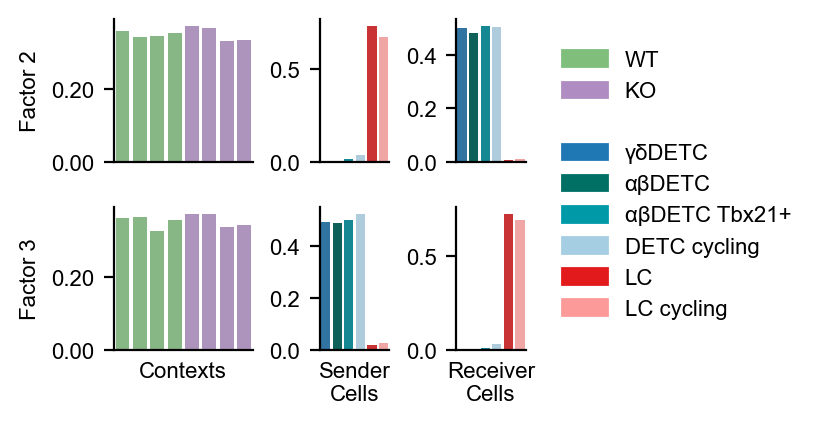

In [ ]:
factors_of_interest = ["Factor 2", "Factor 3"]

contexts = tensor.factors["Contexts"].loc[:, factors_of_interest]
lr_pairs = tensor.factors["Ligand-Receptor Pairs"].loc[:, factors_of_interest]
sender_cells = (
    tensor.factors["Sender Cells"].loc[:, factors_of_interest].reindex(cell_type_order)
)
receiver_cells = (
    tensor.factors["Receiver Cells"]
    .loc[:, factors_of_interest]
    .reindex(cell_type_order)
)

fig = plt.figure(figsize=(100/25.4, 51/25.4), dpi=200, layout="constrained")

gs = gridspec.GridSpec(2, 4, figure=fig, width_ratios=[3, 1.5, 1.5, 3])

for i, context in enumerate(contexts.keys()):
    ax = fig.add_subplot(gs[i, 0])

    sns.barplot(data=contexts.loc[:, context], palette=replicate_colors)

    ax.set_ylabel(
        context,
    )

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    ax.set_xticklabels([])
    ax.set_xticks([])

    if context == "Factor 3":
        ax.set_xlabel("Contexts", )

for i, sender_cell in enumerate(sender_cells.keys()):
    ax = fig.add_subplot(gs[i, 1])

    sns.barplot(data=sender_cells.loc[:, sender_cell], palette=cell_type_colors)

    ax.set_ylabel("")

    ax.set_xticklabels([])
    ax.set_xticks([])

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    if sender_cell == "Factor 3":
        ax.set_xlabel("Sender\nCells", )
    else:
        ax.set_xlabel("")

for i, receiver_cell in enumerate(receiver_cells.keys()):
    ax = fig.add_subplot(gs[i, 2])

    sns.barplot(data=receiver_cells.loc[:, receiver_cell], palette=cell_type_colors)

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    ax.set_ylabel("")

    ax.set_xticklabels([])
    ax.set_xticks([])

    if receiver_cell == "Factor 3":
        ax.set_xlabel("Receiver\nCells", )
    else:
        ax.set_xlabel("")

legend_ax = fig.add_subplot(gs[:, 3])

genotype_patches = [
    mpatches.Patch(color=color, label=label.upper()) for label, color in genotype_colors.items()
]

celltype_patches = [
    mpatches.Patch(color=color, label=label)
    for label, color in {k: cell_type_colors[k] for k in cell_type_order}.items()
]

legend_ax.axis("off")

legend_ax.legend(
    handles=(
        genotype_patches
        + [mpatches.Patch(color="none", label="")]
        + celltype_patches
    ),
    title=None,
    loc="center left",
    frameon=False,
)

plt.show()

## Boxplots

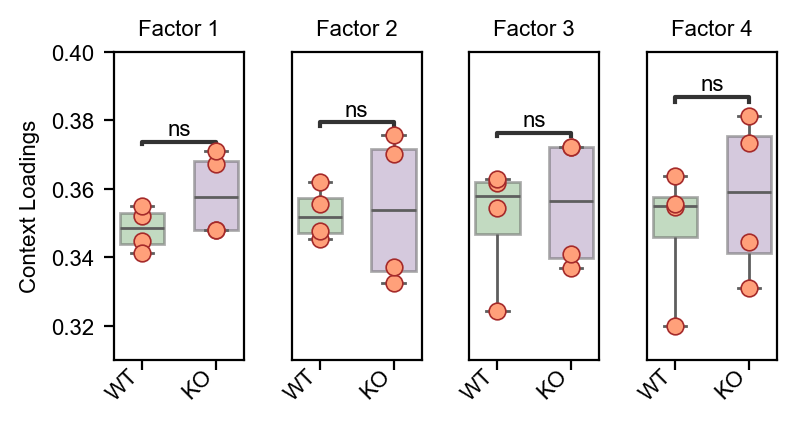

In [ ]:
fig, axes = c2c.plotting.context_boxplot(
    context_loadings=factors["Contexts"],
    metadict=context_dict,
    nrows=1,
    figsize=(98.2635/25.4, 51/25.4),
    statistical_test="t-test_ind",
    pval_correction="fdr_bh",
    cmap=genotype_colors,
    verbose=False,
)

for ax in axes.flatten():
    ax.set_title(ax.get_title(), fontsize=8)
    ax.set_ylabel(ax.get_ylabel(), fontsize=8)
    ax.set_ylim(0.31,0.4)

    ax.set_xticklabels(['WT', 'KO'])

    if ax.get_title() != "Factor 1":
        ax.set_yticks([])
        ax.set_yticklabels([])

plt.subplots_adjust(wspace=0.)
fig.set_constrained_layout(True)

# Supplementary

## Factor barplots all

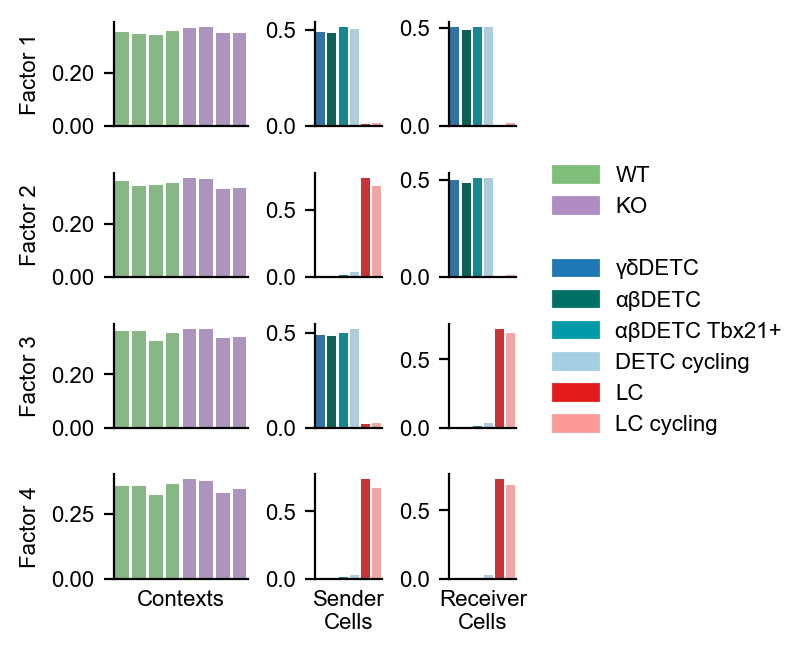

In [ ]:
contexts = tensor.factors["Contexts"]
lr_pairs = tensor.factors["Ligand-Receptor Pairs"]
sender_cells = (
    tensor.factors["Sender Cells"].reindex(cell_type_order)
)
receiver_cells = (
    tensor.factors["Receiver Cells"]
    .reindex(cell_type_order)
)

fig = plt.figure(figsize=(100/25.4, 80/25.4), dpi=200, layout="constrained")

gs = gridspec.GridSpec(4, 4, figure=fig, width_ratios=[3, 1.5, 1.5, 3])

for i, context in enumerate(contexts.keys()):
    ax = fig.add_subplot(gs[i, 0])

    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f"))

    sns.barplot(data=contexts.loc[:, context], palette=replicate_colors)

    ax.set_ylabel(
        context,
    )

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    ax.set_xticklabels([])
    ax.set_xticks([])

    if context == "Factor 4":
        ax.set_xlabel("Contexts", )

for i, sender_cell in enumerate(sender_cells.keys()):
    ax = fig.add_subplot(gs[i, 1])

    sns.barplot(data=sender_cells.loc[:, sender_cell], palette=cell_type_colors)

    ax.set_ylabel("")
    ax.set_xlabel("")

    ax.set_xticklabels([])
    ax.set_xticks([])

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    if sender_cell == "Factor 4":
        ax.set_xlabel("Sender\nCells", )

for i, receiver_cell in enumerate(receiver_cells.keys()):
    ax = fig.add_subplot(gs[i, 2])

    sns.barplot(data=receiver_cells.loc[:, receiver_cell], palette=cell_type_colors)

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    ax.set_ylabel("")
    ax.set_xlabel("")

    ax.set_xticklabels([])
    ax.set_xticks([])

    if receiver_cell == "Factor 4":
        ax.set_xlabel("Receiver\nCells", )

legend_ax = fig.add_subplot(gs[:, 3])

genotype_patches = [
    mpatches.Patch(color=color, label=label.upper()) for label, color in genotype_colors.items()
]

celltype_patches = [
    mpatches.Patch(color=color, label=label)
    for label, color in {k: cell_type_colors[k] for k in cell_type_order}.items()
]

legend_ax.axis("off")

legend_ax.legend(
    handles=(
        genotype_patches
        + [mpatches.Patch(color="none", label="")]
        + celltype_patches
    ),
    title=None,
    loc="center left",
    frameon=False,
)

plt.show()